In [22]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from sklearn.metrics import accuracy_score
import os

In [24]:
def save_fig(img, name, dir = '../output/lda/', keep_axis = True):
    _ , ax = plt.subplots(figsize=(4,4), dpi=100)
    ax.imshow(img, interpolation='nearest')
    if not keep_axis:
        ax.set_axis_off()
    # ax.xaxis.set_major_locator(plt.NullLocator())
    # ax.yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(os.path.join(dir,name), bbox_inches='tight', pad_inches=0, transparent=True, edgecolor='none', facecolor='none')

In [17]:
# Load the dataset
mat = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines.mat')
mat_gt = sio.loadmat('/home/utkarsh/Documents/iitb/gnr602/project/dataset/Indian Pines/Indian_pines_gt.mat')

data = mat['indian_pines']
labels = mat_gt['indian_pines_gt']
print(data.shape)

(145, 145, 220)


In [18]:

class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.scale_ = np.std(X, axis=0)

    def transform(self, X):
        return (X - self.mean_) / self.scale_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [19]:
import numpy as np

def lda(X, y, num_components):
    # compute class means
    means = []
    for c in np.unique(y):
        means.append(np.mean(X[y == c], axis=0))
    
    # compute within-class scatter matrix
    Sw = np.zeros((X.shape[1], X.shape[1]))
    for c, mean in zip(np.unique(y), means):
        class_sc_mat = np.zeros((X.shape[1], X.shape[1]))  
        for row in X[y == c]:
            row, mean = row.reshape(X.shape[1],1), mean.reshape(X.shape[1],1) 
            class_sc_mat += (row-mean).dot((row-mean).T)
        Sw += class_sc_mat  
    
    # compute between-class scatter matrix
    Sb = np.zeros((X.shape[1], X.shape[1]))
    grand_mean = np.mean(X, axis=0).reshape(X.shape[1],1)
    for c, mean in zip(np.unique(y), means):
        n = X[y==c,:].shape[0]
        mean = mean.reshape(X.shape[1],1)
        Sb += n * (mean - grand_mean).dot((mean - grand_mean).T)
    
    # compute eigenvalues and eigenvectors of Sw^-1*Sb
    eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
    eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
    
    # extract the top k eigenvectors as LDA components
    lda_components = np.zeros((X.shape[1], num_components))
    for i in range(num_components):
        lda_components[:, i] = eigen_pairs[i][1]
    
    # project data onto the LDA components
    X_lda = X.dot(lda_components)
    
    return X_lda

/tmp/ipykernel_58748/2759968207.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  lda_components[:, i] = eigen_pairs[i][1]


Accuracy: 0.7466708941027267


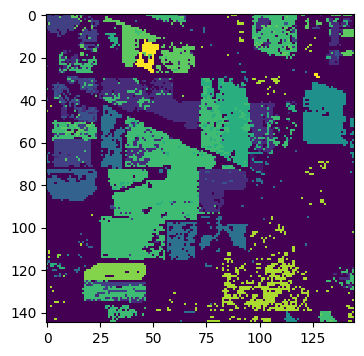

In [25]:
# Reshape the data to (num_samples, num_features)
n, m, num_samples = data.shape
data_reshaped = np.reshape(data, (n*m, num_samples))
labels_reshaped = np.reshape(labels, (n*m,))

# Apply LDA to reduce the dimensionality of the data
num_components = 16
data_scaled = StandardScaler().fit_transform(data_reshaped)
data_lda = lda(data_scaled, labels.ravel(), num_components)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_lda, labels_reshaped, test_size=0.3, random_state=42)

# Create an SVM classifier and train it on the training set
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Evaluate the SVM classifier on the test set
y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Reshape the cluster labels and display the segmented image
cluster_labels = svm.predict(data_lda)
cluster_labels_reshaped = np.reshape(cluster_labels, (n, m))
save_fig(cluster_labels_reshaped, 'lda_svm.png')

In [ ]:
from sklearn.metrics import mean_squared_error

# Reshape the cluster labels to a 1D array
cluster_labels_flat = np.reshape(cluster_labels_reshaped, (n*m,))

# Compute the mean squared error between the predicted labels and the ground truth labels
mse = mean_squared_error(labels_reshaped, cluster_labels_flat)

print("MSE:", mse)

MSE: 24.060975029726517
